# Section the First: The death, child marriage, and slavery of kids books. 


The Dear Canada books are an anthology of childrens books. I love them! Each is from the perspective of a young girl (10-14) living through a moment of Canadian history (wars, natural disasters, political developments, oppression experiences, etc). They can be a signifigant force to shape readers perception of national identity (especially when it is your only ressource for national history, because your province is separatist and only teaches provincial history). 
Many document immigrant experiences. How those experiences might be the most contemporaniously relevant depications for such a high immigration country with tubulent attitudes towards it. So how is it experienced in these books?
This report uses ensemble model sentiment analysis on the foundation of four books from the anthology:

* A Sea of Sorrows: The Typhus Epidemic Diary of Johanna Leary
    * Set in 1847, it follows a young girl immigrating to Canada with her family in response to the potato famine and colonial neglegence affecting Ireland. Both her parents and her baby sibling die before arrival, then her brother is told she is dead and leaves her. She lives for a while in a convent, then works for a disciminatory family, then works for a kind family who essencially absorb her into the family. When things are finally going well, the father is brutally injured while working in the logging industry and that family decides to return to England (it is truly sorrowful), however, they invite her to return with them and she decides to go. At the last minute, her brother finds her and they join their uncle at his farm. 

* With Nothing but Our Courage: The Loyalist Diary of Mary MacDonald
    * Set in 1783, their family are loyal to the Birtish during the American Revolution and are driven from their home. They make the journey to Quebec where the King provides them land and some supplies, but they must restart, are undersupplied and face a harsh winter. They eventually settle in nicely with a community of loyalists. Only one of her family members die, her baby sister. 

* Alone in an Untamed Land: The Filles Du Roi Diary of Helene St. Onge
    * Set in 1666, Helene and her sister are recently orphaned. Helene tags along with her sister, who is a fille du roi (a young woman set to marry and poplutate the colony), and they sail to New France. The odler sister dies, and eventually Helene takes her place as a fille du roi. Life in New France is harsh, with hard winters and threats of Iroquis attack. Eventually, she marries into the Metis community and becomes the step mother to her best-friend. She is 13 at the start of the book and 14 when she marries. 

* A Desperate Road to Freedom: The Underground Railroad Diary of Julia May Jackson
    * Set in 1863, Julias family escapes their forced labour on a Virginia tobacco plantation in response to the emancipation proclaimation. They are desperate to keep their family together, after three of their children have already been sold and lost. They follow the Underground Railroad to Canada, eventually settling in southern Ontario. They build a life there learning new skills to survive in Canada. 

* A Prairie as Wide as the Sea: The Immigrant Diary of Ivy Weatherall
    * Set in 1926, Ivy Weatherall and her family leave a comfortable life in London for the promised riches of Canada's expanding West. They expect to join a well settled family member and to be able to buy their own land, but find themselves living in a sod hut on a rented farm. Ivy recounts learning the new skills expected of a young farm girl. No one dies! 

* Footsteps in the Snow: The Red River Diary of Isobel Scott
    * Set in 1815, the book begins with "Mother is dead." Isobel travels with her two brothers and father amoung the Selkirk Settlers who seek their own land and fortune in Ruperts land (Manitoba). They find themselves caught in the fur-trading rivalry between the Hudson's Bay Company and the North West Company, and struggle seriously with the harsh winters. Their father eventually remarries a Cree woman, and eventually they able to put down roots. 

I read the htm(l) files from the EPUB and assembled them into a txt file. There is some variance in the formatting and file types in the EPUBS, which I mostly adjusted manually, because I only had to do it once, it wasn't very hard, and making the input system infinitely robust just wasn't worth the time. 


Separate to this pipeline, I have the following file:

file: extract_text.py


    import os
    from bs4 import BeautifulSoup

    input_folder = "htm_chapters"
    output_file = "dear_canada_clean.txt"

    all_text = []

    for filename in sorted(os.listdir(input_folder)):
        if filename.endswith(".htm"):			# can be htm or html, just change this line
            path = os.path.join(input_folder, filename)

            with open(path, "r", encoding="utf-8") as f:
                soup = BeautifulSoup(f, "lxml")

                # remove junk
                for tag in soup(["script", "style"]):
                    tag.decompose()

                text = soup.get_text(separator="\n")
                all_text.append(f"\n\n===== {filename} =====\n\n")
                all_text.append(text)

    with open(output_file, "w", encoding="utf-8") as out:
        out.write("\n".join(all_text))

    print("Done! Check dear_canada_clean.txt")

<br>

Which is used in the terminal to read the EPUB,

% pip install beautifulsoup4 lxml

% unzip book.epub -d book_contents

% mkdir htm_chapters

% cp book_contents/OEBPS/*.htm htm_chapters/

% python extract_text.py 


I manually tagged 300 to 400 sentences from each book, excluding front and back matter (eg epilogue, historical note, etc). Each sentence could be any subset of neutral, positive and negative, with respect to their sentiment towards the immigration experience. A sentence like: "Mr. Tattersall has died." would be tagged as neutral, because it does not comment on migration. Whereas "He said it would have been better if Thomas had died at home where he could be buried in the ground with a priest to say words over him, instead of being tossed into the ocean like so much refuse." would be tagged as negative, because, gosh, thats depressing and definitely about the journey. The commentary should be internal to the sentence, so I did my best to understand each phrase outside of my knowlege of the book. This was frequently ambigious and my work is almost certainly dubious. I originally assigned only one tag per sentence, then retagged with any number of tags. This revealed to me how inconsistent I am.

Neutral sentences are signifigantly overrepresented. Naturally, there are more basic sentences then emotionally charged ones, but I suspect because the writing is tailored to kids each individual sentence might, on average, contain less complexity which might worsen the bias.  

# Processing the Data for Labeling

## Section the Second: Bring the Python to the Numpy and force it to drink

The second and third sections repeat, because the data needs to be digestible first for me (so I can tag it) and then reprocessed with those tags to be digestible to the model. 

In [2]:
import re
import pandas as pd
from nltk.tokenize import sent_tokenize
import nltk

In [3]:
# choose the book
txt_file = "text_files/PasWide.txt"

In [ ]:
# read the text file and establishing section markers 
with open(txt_file, "r", encoding="utf-8") as f:
    raw_text = f.read()

'''
We split the books into chapters. The chapter markers are different for each book, so we need to adjust the code accordingly.
This is not strictly necessary for todays analysis, but it is useful for future work and understanding the structure of the books. 
Also, we would have to do something with those markers anyways (as in, otherwise we would clean them away).

Chapter markers:
SofS, DRtoF and FitS:
      ===== c01.htm =====
      ===== cop.htm =====
      ===== (c\d+)\.htm =====

NbutC and AinUTL:
       ===== ch1.html =====
       ===== cop.html =====  
       ===== (ch\d+)\.html =====

PasWide:
       ===== 9781443113342_epub_c01.htm =====
       ===== 9781443113342_epub_cop_r1.htm =====
       ===== (9781443113342_epub_c\d+)\.htm ===== 
       (note that this copy of the book actually doesn't mark chapters at all, but it is not a pressing issue for this assignment so we just pick a stand-in)

'''

start = raw_text.find("===== 9781443113342_epub_c01.htm =====") # <-- adjust these for different books as shown above
end = raw_text.find("===== 9781443113342_epub_cop_r1.htm =====") # <-- 

diary_text = raw_text[start:end]

sections = re.split(r"===== 9781443113342_epub_c(\d+)\.htm =====", diary_text) # <--

chapters = []


date_pattern = r"""
\b(
    # Optional weekday UNCOMMENT only for DRtoF, creates issues for others
    #(?:(?:Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday),?\s+)?    

    # Optional French 'le'
    (?:le\s+)?   

    # Optional leading day number (French)
    (?:\d{1,2}\s+)? 

    # Month
    (?:January|February|March|April|May|June|July|August|September|    
        October|November|December|Janvier|Février|Fevrier|Mars|Avril|Mai|
        Juin|Juillet|Août|Aout|Septembre|Octobre|Novembre|Décembre|Decembre) 

    # Optional English day after month and ordinal suffix
    (?:\s+\d{1,2}(?:st|nd|rd|th)?)?   
    
    # Optional comma
    (?:\s*,?\s*\d{4})?  
)\b
"""

In [5]:
# A chapter dataframe (not really necessary, but I want it to explore the book)
for i in range(1, len(sections), 2):
    chapter_id = sections[i]
    text = sections[i+1]

    match = re.search(date_pattern, text, flags=re.VERBOSE | re.IGNORECASE)
    date = match.group(1) if match else None

    chapters.append({
        "chapter_id": chapter_id,
        "date": date,
        "text": text.strip()
    })

chapters_df = pd.DataFrame(chapters)
chapters_df.head()

,chapter_id,date,text
0,01,"May 1, 1926",Dear Canada: A Prairie as Wide as the Sea\n\n\...


## Section the Third: Fix Yo'self ya dumb data

This data is pretty clean, because it comes from a a quality digital first source. Front and back matter were already removed in the previous section, but there are many many dates (at the start of each diary entry) and chapter formatting which need to be removed. Be aware, the dates for A Desperate Road to Freedom don't come out quite right, but it was an annoying issue to fix with code and easy to fix by hand, so I just did that. Date isn't even used by the model anyways. 

In [6]:
import re
import pandas as pd
from nltk.tokenize import sent_tokenize

def is_valid_sentence(s):
    if len(s) < 7:
        return False

    bad_endings = ("Mrs.", "Mr.", "Miss.", "Dr.", "“", '"')
    if s.endswith(bad_endings):
        return False

    return True


all_rows = []

for _, row in chapters_df.iterrows():

    chapter_id = row["chapter_id"]
    raw_text = row["text"]

    # ---------------------------------------------------------
    # 1. Remove chapter header
    # ---------------------------------------------------------
    text = re.sub(
        r"^Dear Canada:.*?\n+",
        "",
        raw_text,
        flags=re.DOTALL
    ).strip()

    # ---------------------------------------------------------
    # 2. Extract dated entries
    # ---------------------------------------------------------
    matches = list(re.finditer(date_pattern, text, re.VERBOSE | re.IGNORECASE))

    for i, match in enumerate(matches):

        date = match.group()
        start = match.end()
        end = matches[i + 1].start() if i + 1 < len(matches) else len(text)

        entry_text = text[start:end]

        # -----------------------------------------------------
        # 3. Clean entry text
        # -----------------------------------------------------
        entry_text = re.sub(r"\n\s*\n", " ", entry_text)
        entry_text = re.sub(r"\s+", " ", entry_text).strip()

        # -----------------------------------------------------
        # 4. Sentence tokenize
        # -----------------------------------------------------
        sentences = sent_tokenize(entry_text)

        for sentence in sentences:

            sentence = sentence.strip()

            if is_valid_sentence(sentence):
                all_rows.append({
                    "chapter_id": chapter_id,
                    "date": date,
                    "sentence": sentence
                })

sent_df = pd.DataFrame(all_rows)

sent_df.head()

,chapter_id,date,sentence
0,01,"May 1, 1926","107 Halley Road, Forest Gate, London, England ..."
1,01,"May 1, 1926",I am eleven years old.
2,01,"May 1, 1926",This is the first diary I have ever had.
3,01,"May 1, 1926",Auntie Lou gave it to me because she said that...
4,01,"May 1, 1926",The greatest adventure is that we are emigrati...


In [7]:
sample_df = sent_df.sample(frac=1, random_state=42).reset_index(drop=True) # shuffle the sentences and reset the index, for random sampling.
sample_df.to_csv("book_sentences_samples.csv", index=False) # Exporting the cvs so to go get tagged. 

At this point, I went I tagged many, many sentences. The google sheets are linked here:

* A Sea of Sorrows: 
    * https://docs.google.com/spreadsheets/d/1wD1FXjlnSc4dNbAMG-ao3kaJ703kUrh9fN_qmiUsESQ/edit?usp=sharing

* With Nothing but Our Courage:
    * https://docs.google.com/spreadsheets/d/1mNxHFrLdaTxogkuXRKXPAowVM5RVcLqj4_0_fg9J7JY/edit?usp=sharing

* Alone in an Untamed Land: 
    * https://docs.google.com/spreadsheets/d/11Oo0RVQLp67KDq-6aKBtkG4sJUH1M-a48dOulzs0nRw/edit?usp=sharing 

* A Desperate Road to Freedom: 
    * https://docs.google.com/spreadsheets/d/1kUvav-Nw_3gy3ovdhktnaEf96SWWYTk-TzwVFTJ07IY/edit?usp=sharing

* Footsteps in the Snow
    * https://docs.google.com/spreadsheets/d/1lgwuJVaU-7Kv44IyCcicrF-7f_u8I6FdE7L4DFfPrq4/edit?usp=sharing

* A Prarie as Wide as the Sea
    * https://docs.google.com/spreadsheets/d/1fY5A0q57KMEGZ7heqP8C_8vT5zov41t6owsUj_uwfKg/edit?usp=sharing 

# Processing the Data, with labeling, for the Models

## Section the Second-Again: I ran out of fun subheadings ideas :(

Now that I am done with my manual work, we make a new dataframe that the computer will like. Plenty easy now we are only migrating from cvs. 

In [8]:
# Now we have 6 cvs files with tagged sentences. We need to combine them into one dataframe for analysis.

import glob
import os

# path to folder
path = "tagged_sentences/*.csv"

files = glob.glob(path)

dfs = []

for file in files:
    df = pd.read_csv(file)

    # add book identifier from filename
    book_name = os.path.basename(file).replace(".csv", "")
    df["book"] = book_name

    dfs.append(df)

# combine all books
df = pd.concat(dfs, ignore_index=True)

df = df.dropna(subset=["sentence", "book"])

df.head()


,chapter_id,date,sentence,neutral,positive,negative,book
0,ch8,Decembre 1666,"“Well, well.",1,0,0,AinUTL
1,ch9,Janvier 1667,Strands of his hair were stuck to his cheek.,1,0,0,AinUTL
2,ch5,Septembre 1666,"I would wait as well, I answered, and I turned...",1,0,0,AinUTL
3,ch6,Octobre 1666,My income from my business as a merchant is mo...,1,0,0,AinUTL
4,ch5,Septembre 1666,I excused myself and went down to my cabin to ...,1,0,0,AinUTL


## Section the Third-Again: Pre-processing & Feature Engineering 

We have already cleaned our sentences. What's going on in there?

I sampled about 300 or 400 sentences per book. That's vaguely 10% of each book. Th two books I sampled more of (400) was because I was invested in the child marriage plot and because _Nothing but our Courage_ had more minority sentences. I tried my best to meet the appropriate amount of data for this assignment and to make a decent model, but the amount of data is definitly an issue. 

===== Overall Label Counts =====
positive     150
negative     155
neutral     1789
dtype: int64

Total Sentences: 1996


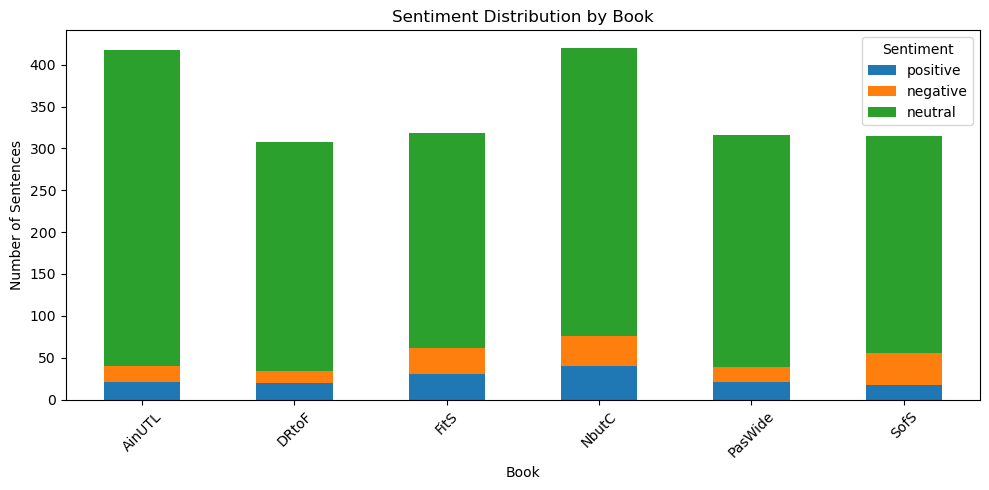

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

#  Overall Label Counts

label_cols = ["positive", "negative", "neutral"]

print("===== Overall Label Counts =====")
total_counts = df[label_cols].sum()
print(total_counts)
print("\nTotal Sentences:", len(df))



#  Stacked Bar Plot by Book
counts_by_book = df.groupby("book")[label_cols].sum()

counts_by_book.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 5)
)

plt.title("Sentiment Distribution by Book")
plt.xlabel("Book")
plt.ylabel("Number of Sentences")
plt.legend(title="Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

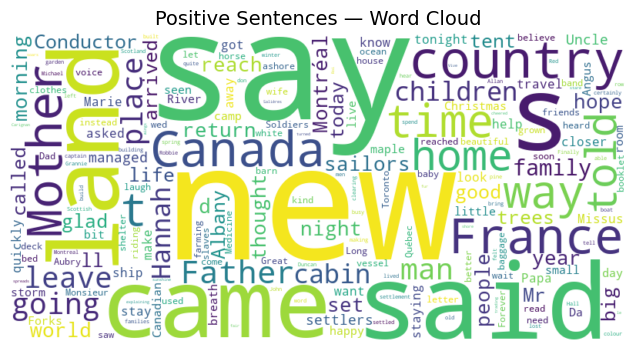

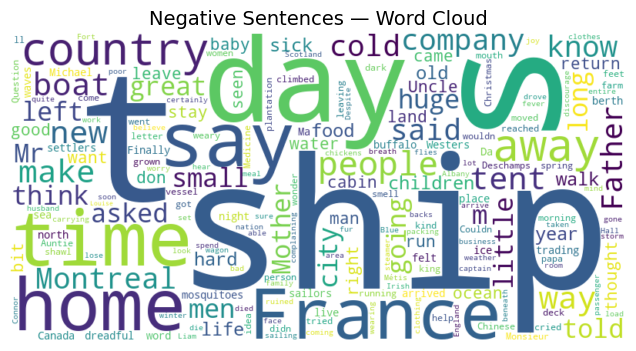

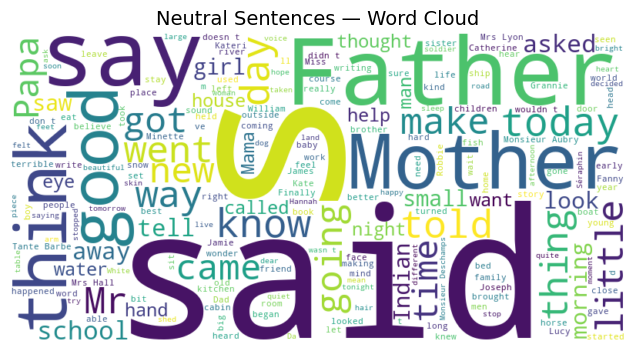

In [10]:
# Word Clouds by Sentiment Category

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Combine stopword lists
stopwords = set(STOPWORDS).union(set(ENGLISH_STOP_WORDS))

# Function to generate word cloud for a category
def generate_wordcloud(label_column, title):

    # Select sentences where label == 1
    text = " ".join(df[df[label_column] == 1]["sentence"].astype(str))

    # Create word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        stopwords=stopwords,
        colormap="viridis"
    ).generate(text)

    # Plot
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()


# Generate clouds
generate_wordcloud("positive", "Positive Sentences — Word Cloud")
generate_wordcloud("negative", "Negative Sentences — Word Cloud")
generate_wordcloud("neutral",  "Neutral Sentences — Word Cloud")

The most obvious takeaway from the clouds that I see, is how absolutely terrible it was to travel by 'ship'. 'Father' and 'mother' are important words for positive and neutral statements, which reflect their importance in all the texts and their lean towards being positive for their child (when they aren't dying). 'New', 'land', 'Canada', 'Country' are frequent in abstract positive reflections about their future, or summary statements as they settle in. 

## BERT, the Translator

We have labeled data now and a sense of what is in it, but the computer does not know whats in each sentence. Here we use BERT, "Bidirectional Encoder Representations from Transformers," to translate that (but not as our model). 

Specifically, we use DistilBert, which is a smaller version of it's larger transformer language model brethern, while achiving similar performance. It is pretrained by knowledge distillation, in a way the 'student' of full BERT. We use DistilBert as a pretrained vector encoder because the emotional tone is often subtle, context-dependent, and linguistically complex. For example, a sentence may appear neutral on the surface but imply fear, regret, or hope through phrasing (“I wish we were still back home…”). A simple bag-of-words or TF-IDF model treats words independently and cannot capture this contextual nuance.

In pretraining, DistilBert learns by optimising three things at once:
* Language modeling loss (It learns to predict masked words in sentences, same as BERT)

* Distillation loss (It is 'taught' by large BERT)

* Cosine-distance loss

### Distilation Loss
In distilation loss, we incorperate a pretrained model into the training process of the smaller model, as shown bellow.

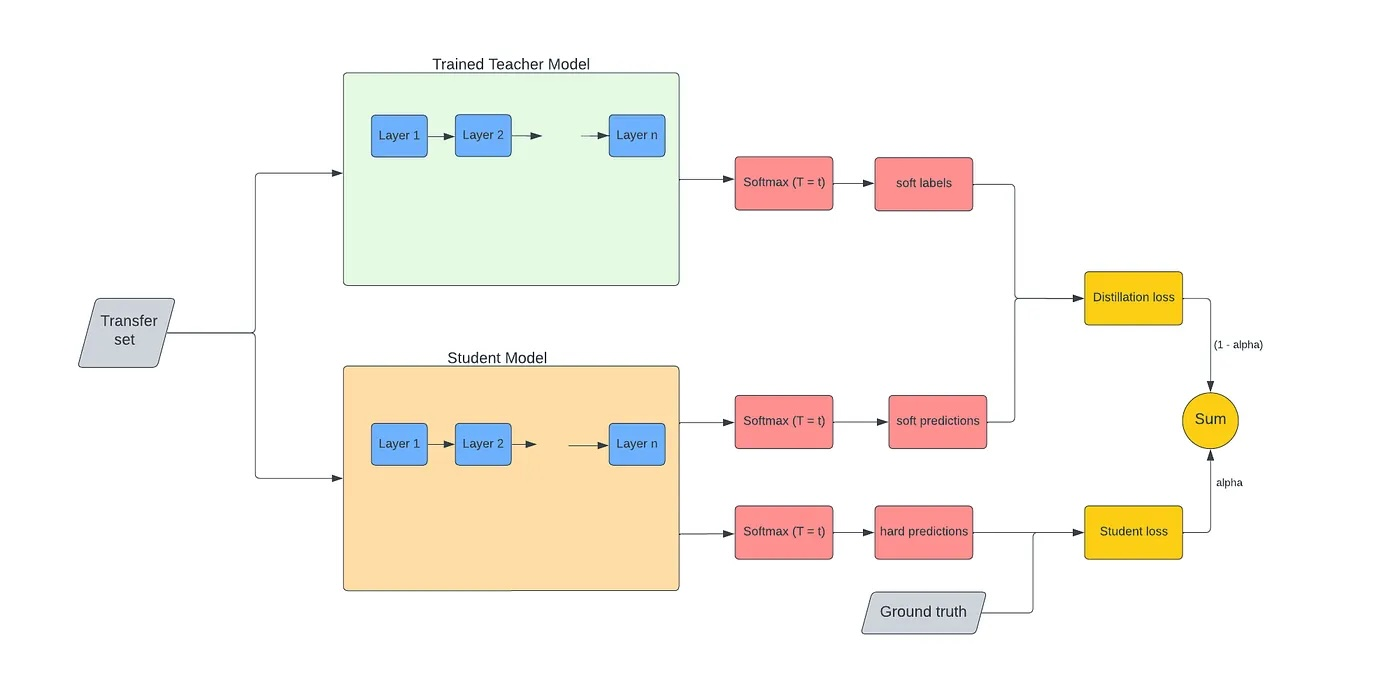

In the case of DistilBert, both the teacher and student models were trained on the same corpus, a concatenation of English Wikipedia and Toronto Book Corpus. A share of this input is reserve from other opperations to act as the transfer set, which is used for the distilation learning. Rather than just DistilBert just observing and responding to it's own predictions for success and failure, it also checks if it agreed with it's teacher model. 

We pass forward through both models, but only back propagate through the student model. 

We predict with the Softmax function:

$$\sigma(z_i) = \frac{e^{\frac{z_{j}}{t}}}{\sum_{j=1}^K e^{\frac{z_{j}}{t}}} \ \ \ for\ i=1,2,\dots,K$$
<br>

The distilation loss is a combination of the teacher and student Softmax, according to KL-divergence loss:

$$D_{KL}(P||Q) = \sum_{i} P(i) \log \frac{P(i)}{Q(i)}$$
<br>

Here, we set the tempurature variable of the Softmax, t, to t > 1, to soften the confidence of the teacher (smoothing the probability distribution) to give the student more informative gradients (in contrast, we have t = 1 to calculate student loss). 

The total loss sum (for distilation) is calculated as:

$$sum = (alpha * Student model loss) + ((1 — alpha)* distillation loss)$$
<br>
<br>

### Cosine embedding loss
Simultaniously, cosine embedding loss is calculated. Cosine loss compares the hidden layer vectors in the teacher and student models to encourage the student’s hidden representations to occupy a similar geometric space as the teacher’s. It is calculated as:
$$cosdist = 1 - \frac{x \cdot y}{|x||y|}$$
<br>
<br>

### Masked language modelling loss
Finally, DistilBert is trained by masking a random subset of words within the training corpus and asking the model to predict those words. Over different epochs different subsets of words are masked. This is independent of the teacher. The teacher model is also trained with masked language modelling loss. 

<br>
<br>

These three forms are taken together in a linear combination to train the student. We could fine tune this model to make predictions for the sentiment class of our text, however, the concern is that there isn't enough data to influence the model appropriately. So instead, we use the sophistication of the DistilBert to generate embeddings that are sensitive to more subtle and complex emotion representation, and use those embeddings to train our own models. 

In [11]:
import torch
from transformers import DistilBertTokenizerFast, DistilBertModel

In [ ]:
# Note, it is safe to ignore the output of this cell. Those are relevant for other tasks, we are only extracting last_hidden_state.

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased") # just indexing into a vocabulary
model = DistilBertModel.from_pretrained("distilbert-base-uncased") # generates contextual embeddings

sentences = df["sentence"].tolist()

encodings = tokenizer(
    sentences,
    padding=True,          # Pad shorter sentences so all inputs in the batch have equal length
    truncation=True,       # Truncate sentences longer than max_length
    max_length=128,        # Maximum number of tokens per sentence (controls memory + compute)
    return_tensors="pt"    # Return PyTorch tensors (required for DistilBERT model)
)


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


torch.Size([1996, 768])

In [13]:
with torch.no_grad():
    outputs = model(**encodings)

last_hidden_state = outputs.last_hidden_state
cls_embeddings = last_hidden_state[:, 0, :]   # shape: (num_sentences, 768)

cls_embeddings.shape # sanity check, should be (num_sentences, 768)

torch.Size([1996, 768])

In [14]:
# returning to numpy
import numpy as np

X = cls_embeddings.numpy()

y_pos = df["positive"].values
y_neg = df["negative"].values
y_neu = df["neutral"].values

print(np.unique(y_pos, return_counts=True)) # sanity check, earlier check revealed a stray typo 11 in the dataset
print(np.unique(y_neg, return_counts=True))
print(np.unique(y_neu, return_counts=True))

(array([0, 1]), array([1846,  150]))
(array([0, 1]), array([1841,  155]))
(array([0, 1]), array([ 207, 1789]))


# Section the Fourth: discussing the analysis

This project uses supervised binary classification to predict whether a sentence expresses a given sentiment about the immigration experience (positive, negative, or neutral). Each sentiment is modeled as a separate task, where the outcome variable is binary (0 = sentiment absent, 1 = sentiment present).

Because the dataset is imbalanced and small, there is concern that totally random assignment to test and training sets could give very very few examples of a minority class in the test set, therefore we use stratified sampling. Stratification preserves the proportion of the minority class within each split, ensuring that both training and test data contain representative examples of the sentiment being modeled.

Each sentiment classifier is trained and evaluated independently using its own stratified 80/20 train–test split. If there was only one split, we could not stratify on both the positive and negative catagories which are about equally rare. 

The dataset is divided into:
* Training set (80%) – used for model training and cross-validation
* Test set (20%) – held out for final out-of-sample evaluation

Cross-validation will be performed on the training set in Section 6 to support model selection and reduce variance in performance estimates.

In [15]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_pos_train, y_pos_test = train_test_split(
    X, y_pos, 
    test_size=0.2,  # 80% training, 20% testing
    random_state=42,    # for reproducibility
    stratify=y_pos     # # Stratify to preserve class balance bc 
)

_, _, y_neg_train, y_neg_test = train_test_split(
    X, y_neg,
    test_size=0.2, 
    random_state=42,
    stratify=y_neg
)

_, _, y_neu_train, y_neu_test = train_test_split(
    X, y_neu, 
    test_size=0.2, 
    random_state=42,
)                       # not stratifying bc the neutral class is the majority


print("Training feature shape:", X_train.shape)
print("Test feature shape:", X_test.shape)

Training feature shape: (1596, 768)
Test feature shape: (400, 768)


In [16]:
from sklearn.model_selection import train_test_split

X_train_pos, X_test_pos, y_pos_train, y_pos_test = train_test_split(
    X,
    y_pos,
    test_size=0.2,       # 80% training, 20% testing
    random_state=42,       # for reproduciblility
    stratify=y_pos      # stratify to preserve class balance, bc the dataset is small + unbalanced
)

X_train_neg, X_test_neg, y_neg_train, y_neg_test = train_test_split(
    X,
    y_neg,
    test_size=0.2,
    random_state=42,
    stratify=y_neg
)

X_train_neu, X_test_neu, y_neu_train, y_neu_test = train_test_split(
    X,
    y_neu,
    test_size=0.2,
    random_state=42,
)


# shape will be the same for each split, but just printing one for sanity check.

print("Training feature shape:", X_train_pos.shape) # should be (num_samples * 0.8, 768) bc we are using the CLS token embedding as features, and it has a dimension of 768
print("Test feature shape:", X_test_pos.shape)


Training feature shape: (1596, 768)
Test feature shape: (400, 768)


# Section the Fifth: model selection

This project evaluates two linear classifiers: Logistic Regression and a Linear Support Vector Machine (SVM). Both models are well-suited for high-dimensional text features (TF-IDF and BERT embeddings) and are computationally efficient.

Because the dataset is highly imbalanced, class weights are set to "balanced" to penalize misclassification of minority classes more heavily.

### Logistic Regression

Logistic regression is a probabilistic linear classifier. It uses Binary Cross-Entropy(BCE), or log loss, which is a performance metric used to train binary classification models by measuring the difference between predicted probabilities (0 to 1) and actual labels (0 or 1)

In binary classification, where the number of classes $M$ equals 2, BCE for a single data point can be calculated as:

$$-{(y\log(p) + (1 - y)\log(1 - p))}$$

Where,

* log - the natural log

* y - binary indicator (0 or 1) if class label c is the correct classification for observation o

* p - predicted probability observation o is of class c



For the whole set of training data, we sum over that formula for all datum and normalise, like:

$$-\frac{1}{N}\sum_{i=1}^N[{(y\log(p) + (1 - y)\log(1 - p))}]$$
<br>
<br>

So, if for this example sentence from A Sea of Sorrows (which we can see is tagged as negative),
c04,"July 3, 1847","I wish we were still back home or at least that we had found a place to stay in England.", 0, 0, 1

if the model confidently (and correctly) predicted it as negative (because we have three binary models), the loss would be 
$$-{(1\log(0.9) + (1 - 1)\log(1 - 0.9))} = 0.105...$$
<br>

but if the model confidently predicted it as _not_ negative, the loss would be 
$$-{(1\log(0.1) + (1 - 1)\log(1 - 0.1))} = 2.303...$$
<br>

and if the model _unconfidently_ predicted it as negative, the loss would be 
$$-{(1\log(0.6) + (1 - 1)\log(1 - 0.6))} = 0.511...$$
<br>

The confident and correct result has the smallest loss, the incorrect result has the largest loss, and the unconfidently correct result has a greater loss then the confident correct result but still a _much_ smaller loss then the incorrect. This is applied to all training data and the model is optimised for minimal loss. 

However, this is vulnerable to uneven catagory representation, which we definitly have. If there simply aren't many examples of negative sentences, it can be optimal to get all not negative examples confidently correct while performing poorly on the minority class. In response to that issue, we can weight the minority class examples more heavily and we can adjust the sensitivity of the classification such that it predicts the minority class when it is less sure (so far, we have implicitly stated that if the probability of it being in the negative class exceeds 0.5, then we will predict it is a negative sentence, but we can make that threshold lower). The 'class_weight' parameter in the code cell bellow addressed the former adjustment, and the latter will be implemented in the next section (section the sixth).


<br>
<br>
<br>

### Linear Support Vector Machine (SVM)

We will disscus the mathmatical underpinnings of SVM less here, because it is yet to be covered, but in breif:

The linear SVM is a margin-based classifier, meaning that it maximizes the margin between classes. Rather then log loss, it is using hinge loss. For one datum, hinge loss can be understood intuitively as,

$$max(0, 1 - y \cdot \hat{y})$$
<br>

Unlike logistic regression, SVM does not directly estimate probabilities. Instead, it focuses on maximizing class separation by imagining the actual class and prediction as vectors. We are also optimising this loss over lots of data, so it is also vulnerable to the minority problem explained above (and improve-able by the same weight balancing feature explained above).

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ),
    "Linear SVM": LinearSVC(
        class_weight="balanced"
    )
}

# Section the Sixth: training the model

To ensure that model performance is robust and not dependent on a single train–test split, we implement k-fold cross-validation on the training data.

Cross-validation helps estimate how well the model generalizes to unseen data and allows for principled hyperparameter tuning.


We use Stratified k-Fold Cross-Validation, which:
* Splits the training data into k folds (e.g., 5)
* Preserves class proportions in each fold
* Trains on k − 1 folds
* Validates on the remaining fold
* Repeats this process k times

Stratification is particularly important due to the strong class imbalance (~90% neutral).

This prevents folds from accidentally containing too few minority examples.
<br>
<br>

### Hyperparameter Tuning and Regularization
While class weighting addresses imbalance by penalizing minority misclassification more heavily, it does not prevent overfitting — particularly when minority classes contain relatively few training examples. For this reason, careful control of model complexity is necessary. We therefore tune the key regularization parameter, regularization strength C, for both models.

Regularization constrains model complexity by penalizing large weight values.In high-dimensional spaces (such as BERT embeddings), models can easily learn highly specific decision boundaries that fit training data closely but fail to generalize to unseen data. This risk is especially acute for minority classes, where the model may “memorize” a small number of examples. Both Logistic Regression and Linear SVM implement L2 regularization, which adds a penalty proportional to the squared magnitude of the weights.

In general, L2 regularization is:
$$Loss = Error(Y - \widehat{Y}) +  \lambda \sum_1^n w_i^{2}$$
<br>

#### The logistic model now optimises:
$$-\frac{1}{N}\sum_{i=1}^N[{(y\log(p) + (1 - y)\log(1 - p))}] +  \frac{\lambda}{2} \sum_1^n w_i^{2}$$
<br>
In scikit-learn, this penalty strength is controlled by:
$$C = \frac{1}{\lambda}$$
so larger C leads to stronger regularisation and smaller C leads to weaker regularisation.
<br>
<br>

#### and Linear SVM:
$$C\sum_{i=1}^N[max(0, 1 - y \cdot \hat{y})]+  \frac{1}{2} \sum_1^n w_i^{2}$$
<br>
The interpretation of C is a bit different for Linear SVM. Here, larger C prioritises minimizing classification error (less margin softness) while smaller C allows for more margin violations, prioritising a simpler boundary. 


We optimise C over a grid search and F1 score as the evaluation metric. The F1 score is a proportion of true positives to false classification (false negatives and false positives), here F1 is with respect to the 'yes' of the binary (as in 'negative' rather then 'not negative', or 'neutral' rather then 'not neutral'). Cross-validation ensures that the selected C generalises across folds.

### Logistic Model Decision Threshold Tuning
While Logistic Regression outputs probabilities, classification requires converting those probabilities into discrete labels. By default, scikit-learn uses a threshold of 0.5. However, in highly imbalanced datasets, a fixed threshold of 0.5 may not maximize performance on the minority class. Because positive and negative sentiments are rare, the model may assign probabilities below 0.5 even when the instance truly belongs to the minority class. Lowering the decision threshold increases recall (detecting more minority examples) at the cost of precision. We can use the F1 score (which balances precision and recall) so that the decision threshold itself can become a tunable hyperparameter without abandoning precision. 

After selecting the best regularization parameter C using cross-validation, we can evaluate thresholds on validation predictions over a set of candidates.

In [18]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Cross-validation strategy
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

param_grid = {
    "C": [0.01, 0.1, 1, 10]
}

train_sets = {
    "Positive": (X_train_pos, y_pos_train),
    "Negative": (X_train_neg, y_neg_train),
    "Neutral":  (X_train_neu, y_neu_train)
}

best_log_models = {}
best_svm_models = {}
best_thresholds = {}

for label, (X_train_split, y_train_split) in train_sets.items():
    
    print(f"\n===== Tuning models for {label} classifier =====")

    # -------------------------
    # Logistic Regression Grid Search
    # -------------------------
    log_grid = GridSearchCV(
        LogisticRegression(max_iter=1000, class_weight="balanced"),
        param_grid,
        cv=cv,
        scoring="f1",
        n_jobs=-1
    )

    log_grid.fit(X_train_split, y_train_split)
    best_log_model = log_grid.best_estimator_
    best_log_models[label] = best_log_model

    print("Logistic Regression Best C:", log_grid.best_params_)
    print("Logistic Regression Best CV F1:", round(log_grid.best_score_, 4))

    # -------------------------
    # Threshold Tuning (Logistic Only)
    # -------------------------
    # Get cross-validated probabilities
    probas = cross_val_predict(
        best_log_model,
        X_train_split,
        y_train_split,
        cv=cv,
        method="predict_proba"
    )[:, 1]

    thresholds = np.arange(0.30, 0.55, 0.05)
    best_f1 = 0
    best_t = 0.5

    for t in thresholds:
        preds = (probas >= t).astype(int)
        f1 = f1_score(y_train_split, preds)

        if f1 > best_f1:
            best_f1 = f1
            best_t = t

    best_thresholds[label] = best_t

    print("Best Decision Threshold:", best_t)
    print("Best Threshold F1:", round(best_f1, 4))

    # -------------------------
    # Linear SVM Grid Search
    # -------------------------
    svm_grid = GridSearchCV(
        LinearSVC(class_weight="balanced"),
        param_grid,
        cv=cv,
        scoring="f1",
        n_jobs=-1
    )

    svm_grid.fit(X_train_split, y_train_split)
    best_svm_models[label] = svm_grid.best_estimator_

    print('------------------------------')
    print("SVM Best C:", svm_grid.best_params_)
    print("SVM Best CV F1:", round(svm_grid.best_score_, 4))


===== Tuning models for Positive classifier =====
Logistic Regression Best C: {'C': 1}
Logistic Regression Best CV F1: 0.4219
Best Decision Threshold: 0.5499999999999999
Best Threshold F1: 0.4422
------------------------------
SVM Best C: {'C': 0.1}
SVM Best CV F1: 0.4119

===== Tuning models for Negative classifier =====
Logistic Regression Best C: {'C': 1}
Logistic Regression Best CV F1: 0.4245
Best Decision Threshold: 0.5499999999999999
Best Threshold F1: 0.4259
------------------------------
SVM Best C: {'C': 0.01}
SVM Best CV F1: 0.4217

===== Tuning models for Neutral classifier =====
Logistic Regression Best C: {'C': 10}
Logistic Regression Best CV F1: 0.9235
Best Decision Threshold: 0.3
Best Threshold F1: 0.9361
------------------------------
SVM Best C: {'C': 10}
SVM Best CV F1: 0.9277


For Logistic Regression, the best regularisation strength was C = 1 for Positive and Negative, and C = 10 for Neutral This suggests that minority classes (Positive/Negative) benefit from moderate regularisation, likely because stronger regularisation (smaller C) would oversimplify an already small signal. For the Neutral classifier, weaker regularisation (larger C) performed best. This makes sense because neutral examples dominate the dataset (~90%), so the model can afford more flexibility without overfitting noise.

For SVM, the optimal C values were even smaller for minority classes (0.1 and 0.01), indicating that margin-based models required stronger regularisation to avoid fitting minority noise.

# Section the Seventh: Prediction Metrics

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

test_sets = {
    "Positive": (X_test_pos, y_pos_test),
    "Negative": (X_test_neg, y_neg_test),
    "Neutral":  (X_test_neu, y_neu_test)
}


for label, (X_test, y_test) in test_sets.items():
    
    print(f"\n\n========== Evaluation for {label} Classifier ==========")

    # -------------------------
    # Logistic Regression
    # -------------------------
    log_model = best_log_models[label]
    threshold = best_thresholds[label]

    probs = log_model.predict_proba(X_test)[:, 1]
    log_preds = (probs >= threshold).astype(int)

    log_precision = precision_score(y_test, log_preds)
    log_recall = recall_score(y_test, log_preds)
    log_f1 = f1_score(y_test, log_preds)
    log_accuracy = accuracy_score(y_test, log_preds)

    print(f"\n--- Logistic Regression ---")
    print(f"Threshold used: {threshold}")
    print(f"Accuracy : {log_accuracy:.4f}")
    print(f"Precision: {log_precision:.4f}")
    print(f"Recall   : {log_recall:.4f}")
    print(f"F1 Score : {log_f1:.4f}")

    # -------------------------
    # Linear SVM
    # -------------------------
    svm_model = best_svm_models[label]
    svm_preds = svm_model.predict(X_test)

    svm_precision = precision_score(y_test, svm_preds)
    svm_recall = recall_score(y_test, svm_preds)
    svm_f1 = f1_score(y_test, svm_preds)
    svm_accuracy = accuracy_score(y_test, svm_preds)

    print(f"\n--- Linear SVM ---")
    print(f"Accuracy : {svm_accuracy:.4f}")
    print(f"Precision: {svm_precision:.4f}")
    print(f"Recall   : {svm_recall:.4f}")
    print(f"F1 Score : {svm_f1:.4f}")



========== Evaluation for Positive Classifier ==========

--- Logistic Regression ---
Threshold used: 0.5499999999999999
Accuracy : 0.8600
Precision: 0.2903
Recall   : 0.6000
F1 Score : 0.3913

--- Linear SVM ---
Accuracy : 0.8575
Precision: 0.2985
Recall   : 0.6667
F1 Score : 0.4124


========== Evaluation for Negative Classifier ==========

--- Logistic Regression ---
Threshold used: 0.5499999999999999
Accuracy : 0.8650
Precision: 0.3051
Recall   : 0.5806
F1 Score : 0.4000

--- Linear SVM ---
Accuracy : 0.8475
Precision: 0.2857
Recall   : 0.6452
F1 Score : 0.3960


========== Evaluation for Neutral Classifier ==========

--- Logistic Regression ---
Threshold used: 0.3
Accuracy : 0.8725
Precision: 0.9433
Recall   : 0.9148
F1 Score : 0.9289

--- Linear SVM ---
Accuracy : 0.8575
Precision: 0.9424
Recall   : 0.8984
F1 Score : 0.9198



For minority classes, accuracy is high (~0.85), but this is misleading due to class imbalance. The important metrics are:
* Precision ≈ 0.29–0.31
* Recall ≈ 0.58–0.67
* F1 ≈ 0.39–0.41

The models prioritize recall over precision, meaning they are relatively good at finding minority cases but at the cost of false positives. This is consistent with our choices to make class_weight="balanced" and to adjust the probability thresholds. I would rather be too sensitive to minority classes, calling everything neutral would just be uninteresting, and there is a strong relationship between general negativity or positivity and negativity or positivity about immigration. If the whole book is about immigration, any either minority sentiment will be, in some capacity, related to the immigration. 

The SVM slightly outperforms Logistic Regression on F1 for Positive sentiment, while results are similar for Negative.

Overall, the results are modest. The dataset is too small and the concept is too muddled. 

The performance for the neutral class if better. It has more data and it is conceptually clearer. 

Logistic Regression and SVM perform similarly overall.

# Section the Eigth: visualising the results

Let's visualise the result metrics and see how this looks in practice. 

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

def visualize_results(test_sets, best_log_models, best_svm_models, best_thresholds):

    for label, (X_test, y_test) in test_sets.items():

        print(f"\n\n========== Visualisations for {label} Classifier ==========")

        models_to_plot = [
            ("Logistic Regression", best_log_models[label], best_thresholds[label]),
            ("Linear SVM", best_svm_models[label], None)
        ]

        for model_name, model, threshold in models_to_plot:

            if model_name == "Logistic Regression":
                probs = model.predict_proba(X_test)[:, 1]
                preds = (probs >= threshold).astype(int)
                scores = probs
            else:
                preds = model.predict(X_test)
                if hasattr(model, "decision_function"):
                    scores = model.decision_function(X_test)
                elif hasattr(model, "predict_proba"):
                    scores = model.predict_proba(X_test)[:, 1]
                else:
                    scores = None

            fig, axes = plt.subplots(1, 2, figsize=(12, 4))

            cm = confusion_matrix(y_test, preds)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(ax=axes[0], colorbar=False)
            axes[0].set_title(f"{model_name} — {label} (Confusion Matrix)")

            if scores is not None:
                fpr, tpr, _ = roc_curve(y_test, scores)
                roc_auc = auc(fpr, tpr)
                axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
                axes[1].plot([0, 1], [0, 1], linestyle="--")
                axes[1].set_xlabel("False Positive Rate")
                axes[1].set_ylabel("True Positive Rate")
                axes[1].set_title(f"{model_name} — {label} (ROC Curve)")
                axes[1].legend()
            else:
                axes[1].text(0.5, 0.5, "ROC not available", ha="center", va="center")
                axes[1].set_axis_off()

            plt.tight_layout()
            plt.show()



========== Visualisations for Positive Classifier ==========


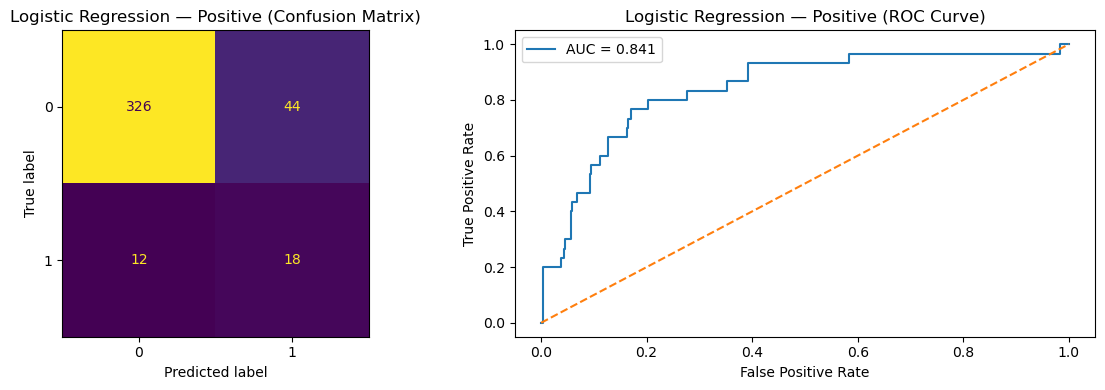

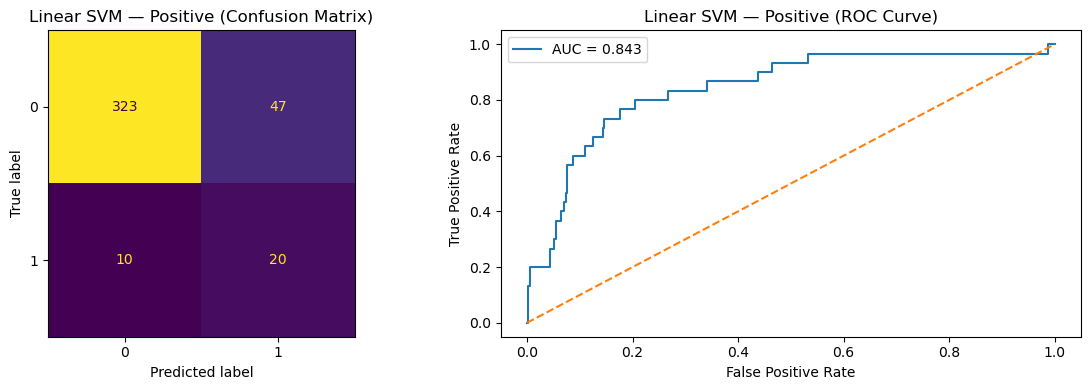



========== Visualisations for Negative Classifier ==========


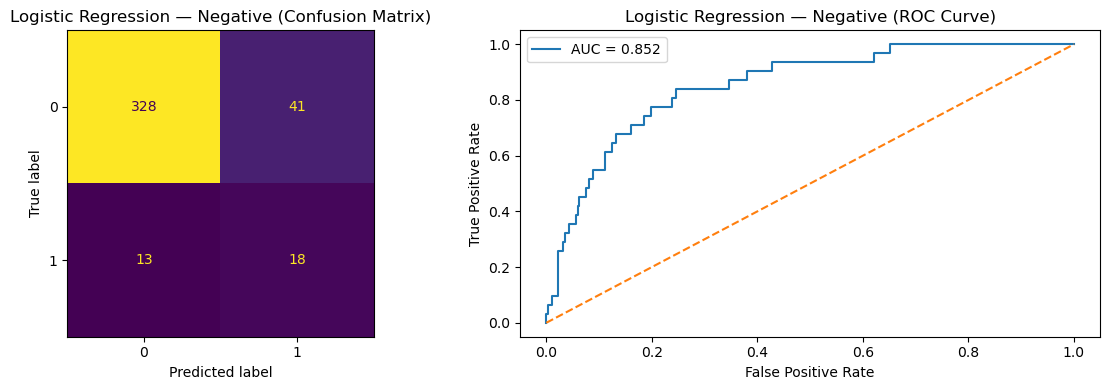

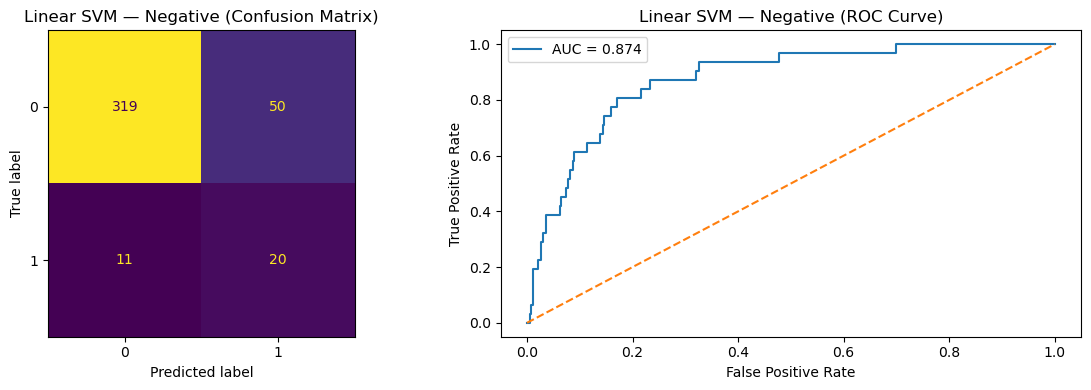



========== Visualisations for Neutral Classifier ==========


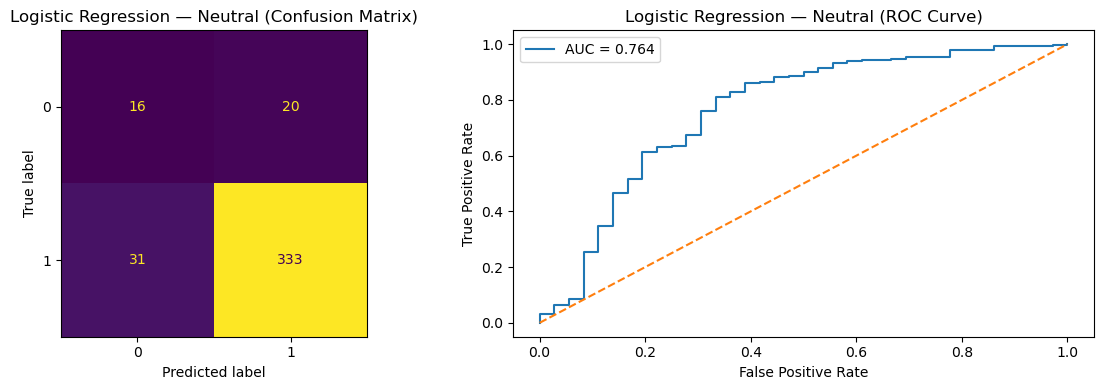

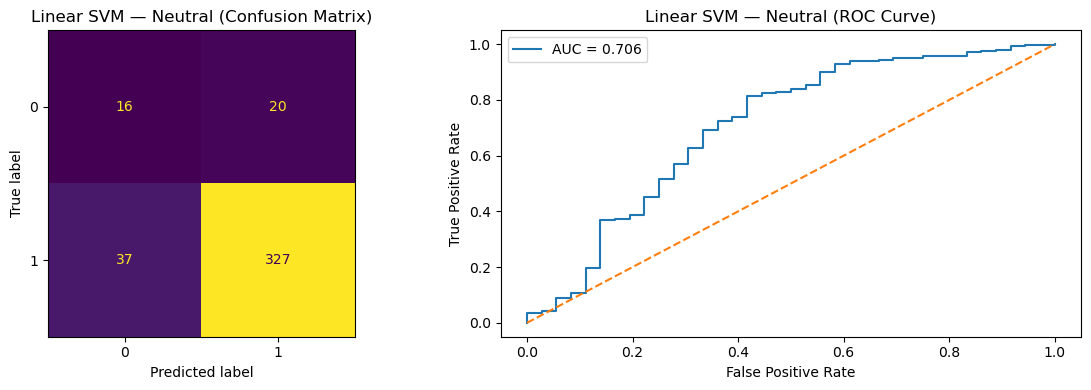

In [21]:
test_sets = {
    "Positive": (X_test_pos, y_pos_test),
    "Negative": (X_test_neg, y_neg_test),
    "Neutral":  (X_test_neu, y_neu_test)
}

visualize_results(test_sets, best_log_models, best_svm_models, best_thresholds)

These results show a similar story to the metrics above. For our minority classes, with both models, we find about 2/3rds of class and the number of false positives is about double the true positives. Not inspiring, but not trash either. 
The neutral catagory finds most neutral sentences, but is muddled terribly in all other capacities. Essencially, it is struggling with class imbalance as well. 

### What does this look like in practice?

We have many metrics and evaluations at this point, but let's return to an application. How would this work with a coherant set of text?

Here we create a dataframe of new sentences taken as a paragragh from a sea of sorrows, which I have assigned sentiment with my own judgement, and compare the results of the logistic model. 

In [22]:
def predict_manual_segment(
    sentences,
    manual_labels,
    tokenizer,
    bert_model,
    best_log_models,
    best_svm_models,
    best_thresholds,
    model_type="logistic",
    max_length=128
):

    labels = ["Positive", "Negative", "Neutral"]

    manual_df = pd.DataFrame(
        manual_labels,
        columns=[f"{label}_manual" for label in labels]
    )

    manual_df["sentence"] = sentences

    # Generate embeddings
    encodings = tokenizer(
        sentences,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

    with torch.no_grad():
        outputs = bert_model(**encodings)

    X_manual = outputs.last_hidden_state[:, 0, :].numpy()

    # Choose model dict
    model_dict = best_log_models if model_type == "logistic" else best_svm_models

    for label in labels:

        model_clf = model_dict[label]

        if model_type == "logistic":

            threshold = best_thresholds[label]
            probs = model_clf.predict_proba(X_manual)[:, 1]
            preds = (probs >= threshold).astype(int)

            manual_df[f"{label}_score"] = probs  # true probabilities

        else:  # SVM

            preds = model_clf.predict(X_manual)
            manual_df[f"{label}_score"] = preds  # binary map only

        manual_df[f"{label}_pred"] = preds

    manual_df["model_type"] = model_type

    return manual_df

In [23]:
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt


def plot_segment_heatmaps(manual_df):

    labels = ["Positive", "Negative", "Neutral"]

    if "model_type" not in manual_df.columns:
        raise ValueError("manual_df must include 'model_type' column.")

    model_type = manual_df["model_type"].iloc[0]

    score_matrix = manual_df[
        [f"{label}_score" for label in labels]
    ].values

    manual_matrix = manual_df[
        [f"{label}_manual" for label in labels]
    ].values

    pred_matrix = manual_df[
        [f"{label}_pred" for label in labels]
    ].values

    # ----------------------------
    # Build outcome matrix fresh
    # ----------------------------
    outcome_matrix = np.zeros_like(pred_matrix)

    for i in range(pred_matrix.shape[0]):
        for j in range(pred_matrix.shape[1]):

            m = manual_matrix[i, j]
            p = pred_matrix[i, j]

            if m == 1 and p == 1:
                outcome_matrix[i, j] = 1  # TP
            elif m == 0 and p == 0:
                outcome_matrix[i, j] = 0  # TN
            elif m == 0 and p == 1:
                outcome_matrix[i, j] = 2  # FP
            elif m == 1 and p == 0:
                outcome_matrix[i, j] = 3  # FN

    n_sentences = len(manual_df)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # =========================================================
    # 1️⃣ Prediction Panel
    # =========================================================

    im1 = axes[0].imshow(score_matrix, aspect="auto")
    title = "Predicted Probabilities" if model_type == "logistic" else "Predicted Classes (SVM)"
    axes[0].set_title(title)

    axes[0].set_xticks(np.arange(len(labels)))
    axes[0].set_xticklabels(labels)
    axes[0].set_yticks(np.arange(n_sentences))
    axes[0].set_yticklabels(range(1, n_sentences + 1))

    for i in range(n_sentences):
        for j in range(len(labels)):
            if model_type == "logistic":
                text = f"{score_matrix[i, j]:.2f}"
            else:
                text = str(int(score_matrix[i, j]))

            axes[0].text(j, i, text, ha="center", va="center")

    plt.colorbar(im1, ax=axes[0])

    # =========================================================
    # 2️⃣ Manual Labels Panel
    # =========================================================

    manual_cmap = ListedColormap(["#F0F0F0", "#029386"])
    im2 = axes[1].imshow(manual_matrix, aspect="auto", cmap=manual_cmap, vmin=0, vmax=1)

    axes[1].set_title("Manual Classification")
    axes[1].set_xticks(np.arange(len(labels)))
    axes[1].set_xticklabels(labels)
    axes[1].set_yticks(np.arange(n_sentences))
    axes[1].set_yticklabels(range(1, n_sentences + 1))

    # Restore text labels
    for i in range(n_sentences):
        for j in range(len(labels)):
            axes[1].text(
                j, i,
                str(int(manual_matrix[i, j])),
                ha="center",
                va="center"
            )

    plt.colorbar(im2, ax=axes[1]).set_label("1 = Assigned")

    # =========================================================
    # 3️⃣ Outcome Panel
    # =========================================================

    outcome_cmap = ListedColormap([
        "#4C72B0",  # TN
        "#55A868",  # TP
        "#FFB000",  # FP
        "#C44E52"   # FN
    ])

    im3 = axes[2].imshow(outcome_matrix, aspect="auto", cmap=outcome_cmap, vmin=0, vmax=3)

    axes[2].set_title("Prediction Outcome Type")
    axes[2].set_xticks(np.arange(len(labels)))
    axes[2].set_xticklabels(labels)
    axes[2].set_yticks(np.arange(n_sentences))
    axes[2].set_yticklabels(range(1, n_sentences + 1))

    outcome_labels = {0: "TN", 1: "TP", 2: "FP", 3: "FN"}

    for i in range(n_sentences):
        for j in range(len(labels)):
            axes[2].text(
                j, i,
                outcome_labels[outcome_matrix[i, j]],
                ha="center",
                va="center",
                fontsize=9
            )

    plt.tight_layout()
    plt.show()

--- Logistic Regression Performance ----------------->


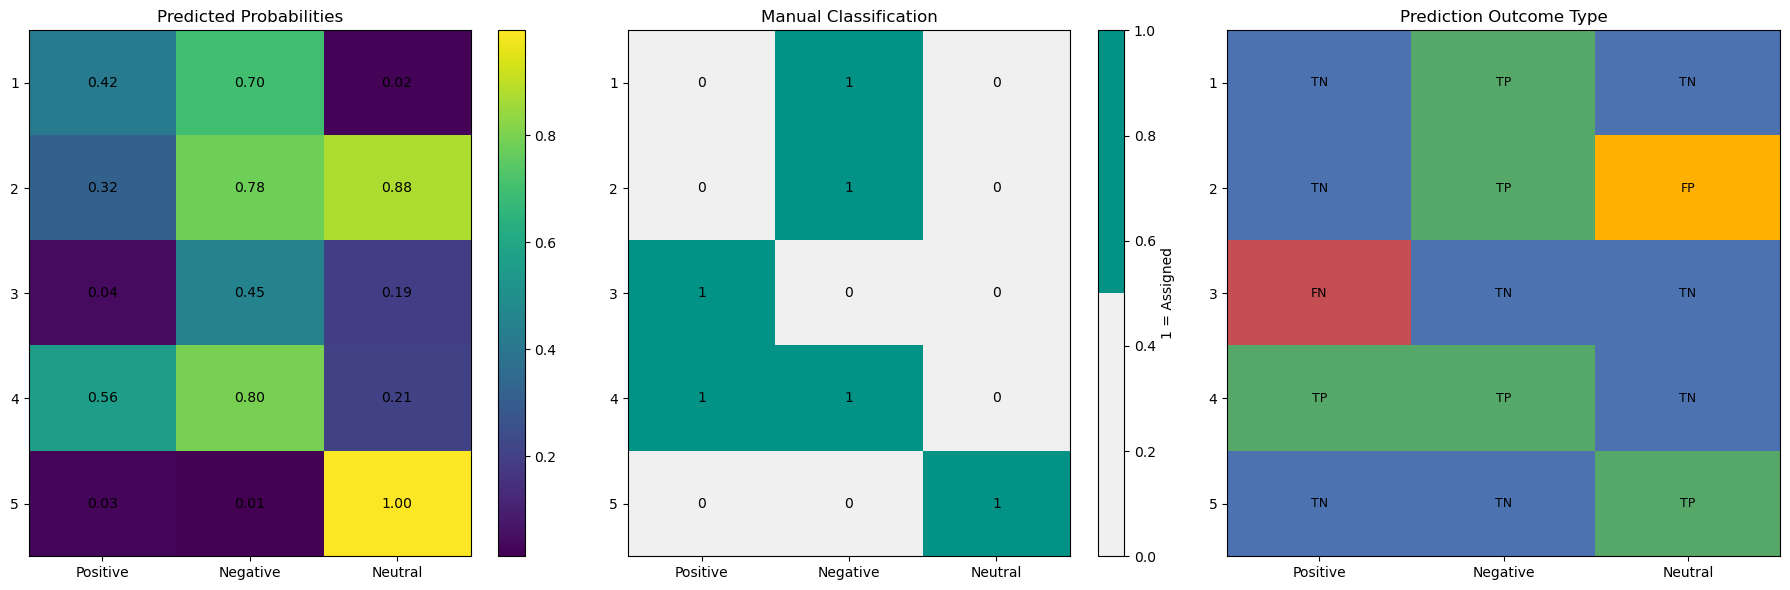

In [24]:
manual_sentences = [
    "Later, Connor told me that he heard Mr. Kelleher say that he was sorry he ever left Ireland.",
    "He said it would have been better if Thomas had died at home where he could be buried in the ground with a priest to say words over him, instead of being tossed into the ocean like so much refuse",
    "Michael argued that if the Kellehers had stayed home, they would likely be dead from starvation by now.",
    "“At least we have food on the ship, however poor it is,” he said.”",
    "Connor agreed."
]


# Multi-label manual assignment (Positive, Negative, Neutral)
manual_labels = [
    [0, 1, 0],  # Negative
    [0, 1, 0],  # Negative
    [1, 0, 0],  # Positive 
    [1, 1, 0],  # Negative + Positive
    [0, 0, 1]   # Neutral
]

manual_df = predict_manual_segment(
    manual_sentences,
    manual_labels,
    tokenizer,
    model,
    best_log_models,
    best_svm_models,
    best_thresholds,
    model_type="logistic"
)

print("--- Logistic Regression Performance ----------------->")
plot_segment_heatmaps(manual_df)

--- Linear SVM Performance ----------------->


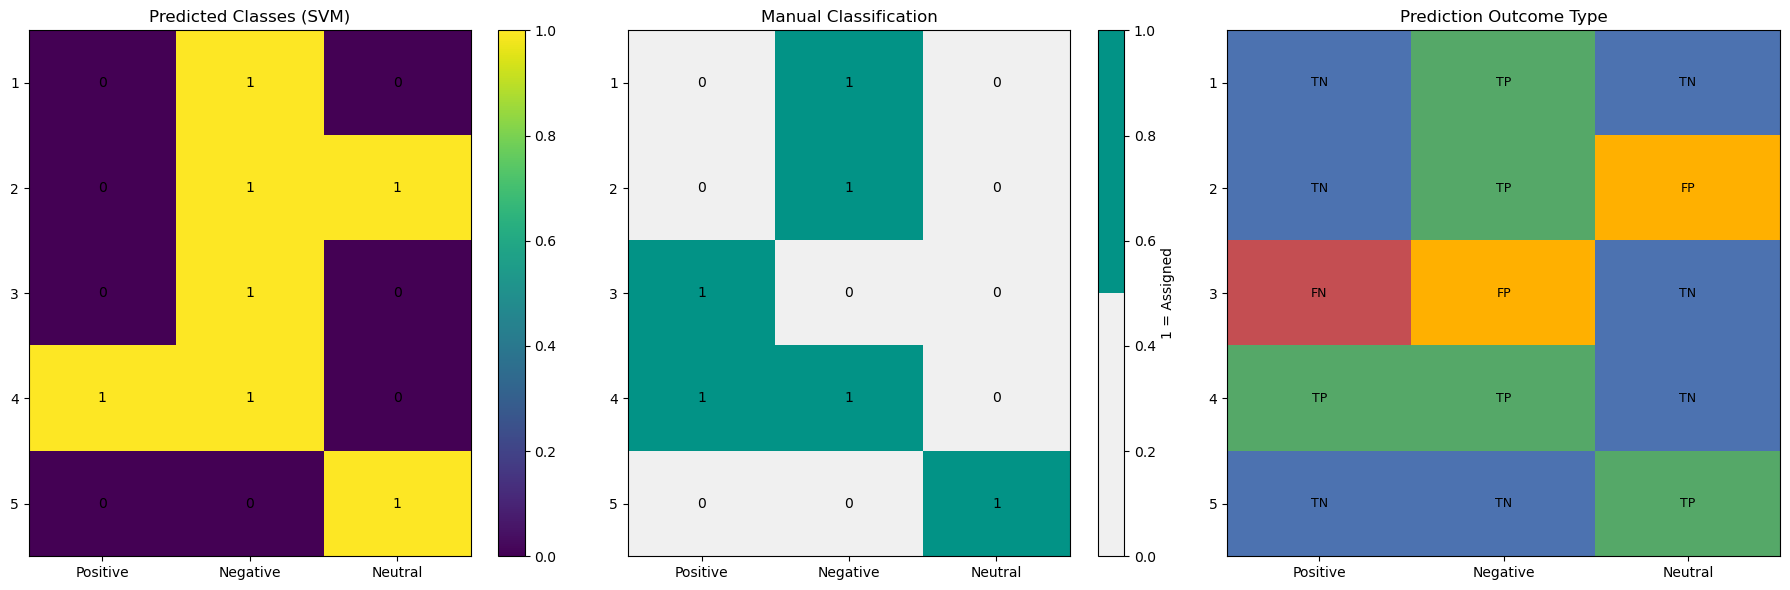

In [25]:
manual_df = predict_manual_segment(
    manual_sentences,
    manual_labels,
    tokenizer,
    model,
    best_log_models,
    best_svm_models,
    best_thresholds,
    model_type="svm"
)


print("--- Linear SVM Performance ----------------->")
plot_segment_heatmaps(manual_df)

Both models do pretty well for this example. They are both wholly correct about: 
* "Later, Connor told me that he heard Mr. Kelleher say that he was sorry he ever left Ireland."
As they should be; it is a very explict statement. 

Both models performed the same for;
* "He said it would have been better if Thomas had died at home where he could be buried in the ground with a priest to say words over him, instead of being tossed into the ocean like so much refuse" 
Correctly identifying that it isn't positive, is negative, and falsely thinking it is neutral. I wonder if it is the length and quantity of 'construction' words, such as "He said it would have been". 'Said' and 'say' are both signifigant in the word cloud for the neutral catagory. 

The models diverge for:
* "Michael argued that if the Kellehers had stayed home, they would likely be dead from starvation by now."
Logistic regression doesn't classify it as anything (which perhaps suggests an avenue for improvement, because that should never happen), and very nearly classifies it as negative. Linear SVM does make that mistake, it calls the sentence negative. To be fair, it sounds negative; only it is positive about immigration. 


Proudly, they both correctly identified this sentence:
* "“At least we have food on the ship, however poor it is,” he said.”"
As negative and positive. Both models made a mistake with this sentence until the most recent addition of the _Footsteps in the Snow_ data. 'Ship' probably helps identify this sentence as relating to immigration.


They both were correct about:
* "Connor agreed." 
Which is an easy win. 


All in all, it is a mostly negative-sentiment paragraph, which is identified. However, I must admit, part of why I chose this example text is because it felt less ambigious then others. I felt more confident in my labels. In that way, it is an easy test, on which it only performs moderately well. The more complete picture is captured by the metrics. 

--- Logistic Regression Performance ----------------->


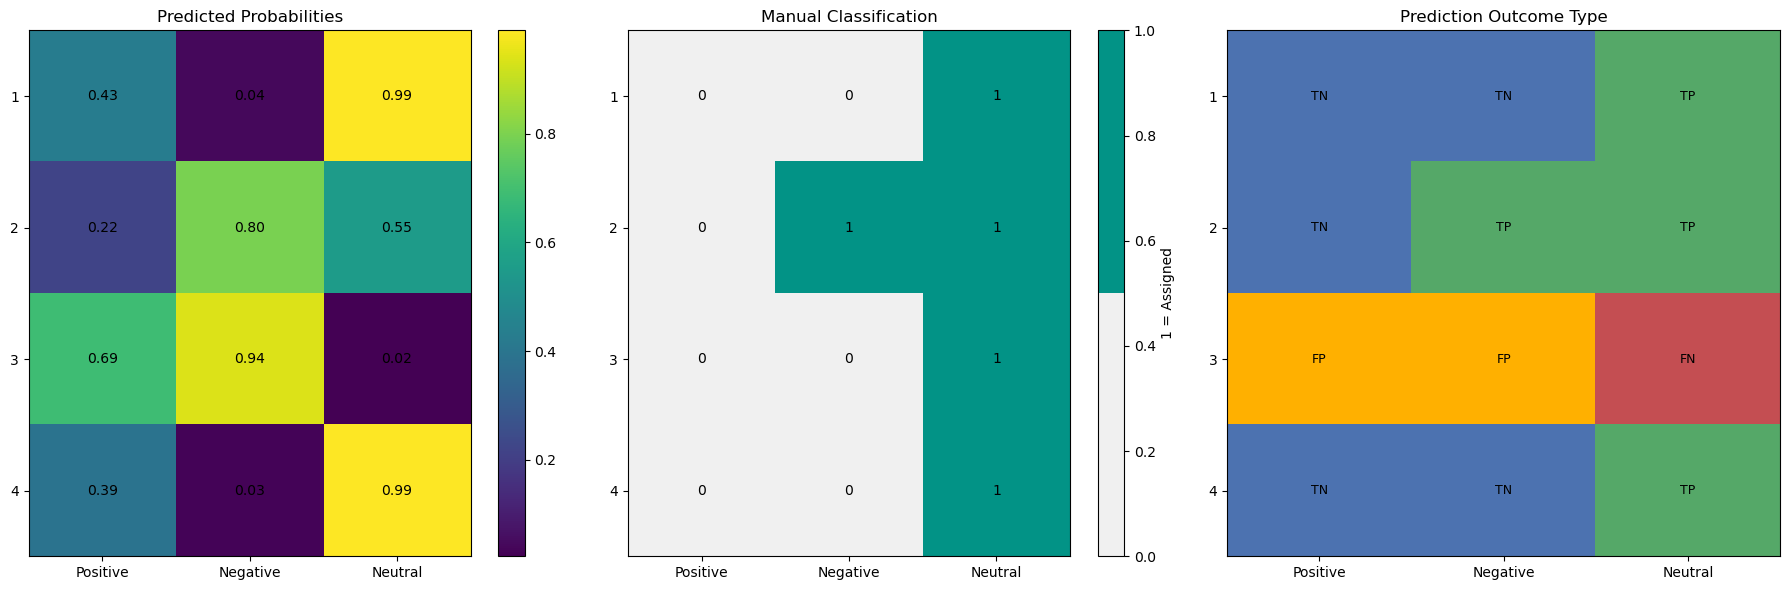

In [35]:
manual_sentences = [
    "The wind is howling outside, but all is safe and peaceful in this little house.",
    "We still do not have much.",
    "We will have to husband our supplies very carefully to get through this winter, but I am certain we will make it.",
    "And tomorrow I will start on a quilt."
    ]



# Multi-label manual assignment (Positive, Negative, Neutral)
manual_labels = [
    [0, 0, 1],  # Neutral
    [0, 1, 1],  # Neutral, negative
    [0, 0, 1],  # Neutral 
    [0, 0, 1]  # Neutral
]

manual_df = predict_manual_segment(
    manual_sentences,
    manual_labels,
    tokenizer,
    model,
    best_log_models,
    best_svm_models,
    best_thresholds,
    model_type="logistic"
)

print("--- Logistic Regression Performance ----------------->")
plot_segment_heatmaps(manual_df)

--- Linear SVM Performance ----------------->


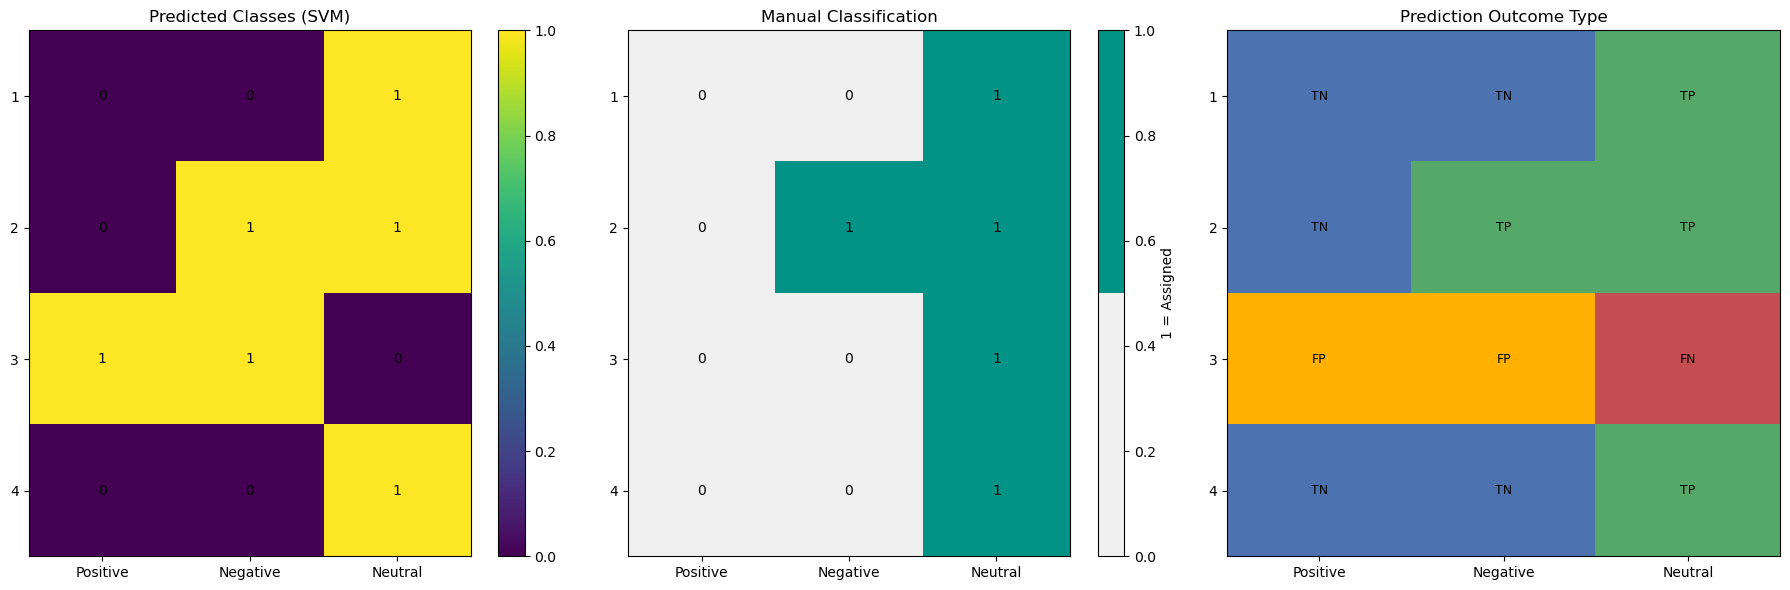

In [36]:
manual_df = predict_manual_segment(
    manual_sentences,
    manual_labels,
    tokenizer,
    model,
    best_log_models,
    best_svm_models,
    best_thresholds,
    model_type="svm"
)


print("--- Linear SVM Performance ----------------->")
plot_segment_heatmaps(manual_df)

This example was supposed to be an example of ambiguity and the model performing worse. This is the final paragraph of _With Nothing but our Courage_. It says little explicitly about immigration, but clearly it is a reflection on the families future in Canada. The one sentence where the both models perform poorly, 
* "We will have to husband our supplies very carefully to get through this winter, but I am certain we will make it."
Is a borderline statement, which I was unsure what to label. It labels the sentence as positive and negative. If you accept that it is about immigration, it absolutely is positive and negative. I think it arguably out-performed my own classification. 

# Section the Nineth: executive summary

This project set out to build a multi-label sentence-level sentiment classifier capable of identifying Positive, Negative, and Neutral tones simultaneously within narrative text. This was treated  as a multi-label problem rather than a traditional multiclass task because emotional categories are rarely mutually exclusive; a sentence may express gratitude and grief at the same time. Especially in the context of books with a tendancy to be depressing, yet never too depressing for kids and always ending happily. 

In retrospective, it has become obvious that two tasks were muddled here. There is one classification problem, to identify whether a sentence is related to immigration, and another classification problem, to identify what sentiment each sentence communicates. I believe that labeling system and approach would radically change the class imbalance issue, which is the major limiting factor, aside from shear quantity of data. The _With Nothing but Our Courage_ example paragraph shows the fundemental labeling scheme issue too; the models  classification made more sense then the actual labels. I was too deep in data labeling to change systems, especially because I already had once. 

We chose to represent sentences using DistilBERT CLS embeddings rather than traditional bag-of-words or TF-IDF features. This decision prioritized contextual meaning over lexical frequency. Because the dataset was not large enough to justify fine-tuning a transformer model end-to-end, we froze DistilBERT and used it strictly as a feature extractor. DistilBert has millions of parameters, so fine tuning it on so few minority class examples likely lead to overfitting and high variance across runs. The current approach allowed us to test how far high-quality pretrained embeddings could carry relatively simple linear classifiers.

For classification, we implemented both Logistic Regression and Linear SVM models, training three independent classifiers—one for each sentiment label. This independence assumption is structurally imperfect. Positive and Negative labels, for example, are not statistically independent in practice. However, decoupling them allowed us to tune each model individually and interpret each boundary separately. It also made threshold tuning feasible in a clean and controlled way.

Regularization became especially important because we were working in a 768-dimensional embedding space. Without L2 regularization, the models could easily overfit, especially given class imbalance. The hyperparameter C was tuned per label, and we observed that optimal regularization strength varied across Positive, Negative, and Neutral tasks. Classification threshold for Logistic Regression was also tuned. Elsewhere, we prioritise recall (for example, by balancing the class weight) but here we optimise with F1 for balance with precision and actually increase the threshold. 

The manual sentence-level evaluation section provided the most illuminating diagnostic. The heatmaps visualizing predicted probabilities, manual labels, and correctness matrices make visible what aggregate metrics obscure. For clearly polarized sentences, the models performed confidently and correctly. For emotionally mixed sentences, predictions were often split across labels—sometimes correctly reflecting complexity, sometimes revealing ambiguity in the learned boundary. The Neutral category in particular showed instability, suggesting either labeling ambiguity or weaker signal in embedding space.

Interestingly, Linear SVM and Logistic Regression often produced similar large-scale performance patterns. Linear SVM performed slightly better, but the probabilistic nature of Logistic Regression made it more interpretable and tunable. We could apply these models to average sentence level prediction/probabilities over each diary entry, to see the high level progression of immigration sentiment, in which case the probabilities of Logistic regression might be more informative then the prediction of SVM. 

There are clear limitations. First, embeddings were frozen; we did not adapt the representation space to the task. Second, labels were modeled independently, ignoring structural relationships between sentiments. Third, all decision boundaries were linear. Emotional tone in narrative text may not be linearly separable in embedding space. More then anything, the data needs to be revised and there needs to be more of it. 

Despite these limitations, the pipeline demonstrates that contextual embeddings combined with relatively simple linear classifiers can produce meaningful multi-label sentiment predictions. Unsupervised learning might suggest a route around the current data issues. 

# Section the Tenth: references

I used this site:
https://blmoistawinde.github.io/ml_equations_latex/
for the latex equations included. While I was only looking to save that time typing, I actually found it to be a usefully concise and comprehensive overview. 

The Bert knowlege transfer diagram was taken from this article: https://arunm8489.medium.com/understanding-distil-bert-in-depth-5f2ca92cf1ed. Which also informed that section generally, alongside the Huggingface documentation and an assortment of articles I skimmed or referenced for something particular. 

I consulted Jacopo, from our class, informally over dinner while visiting his girlfriends apartment. His main contribution was the suggestion of DistilBERT. 

I used ChatGPT quite a lot. We have had one continous conversation over weeks. I used it much more then normal in the planning phases to disscus my plans before starting. It wrote most of the code here, although I don't think any of it was working and sufficient in the first few iterations. The chat link is here: https://chatgpt.com/share/69951fc7-e9fc-800d-b29d-27c292cc7694

You can see this assignment on Github here: https://github.com/SS-Bird/dear-canada-ml- 